# Determining absolute hydration free energy offsets

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Global-variables" data-toc-modified-id="Global-variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Global variables</a></span></li><li><span><a href="#Feature-generation" data-toc-modified-id="Feature-generation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature generation</a></span><ul class="toc-item"><li><span><a href="#Descriptors" data-toc-modified-id="Descriptors-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Descriptors</a></span></li><li><span><a href="#Fingerprints" data-toc-modified-id="Fingerprints-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Fingerprints</a></span></li><li><span><a href="#Compile-features" data-toc-modified-id="Compile-features-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Compile features</a></span></li><li><span><a href="#Remove-columns-with-string-values" data-toc-modified-id="Remove-columns-with-string-values-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Remove columns with string values</a></span></li><li><span><a href="#Convert-all-values-to-float" data-toc-modified-id="Convert-all-values-to-float-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Convert all values to float</a></span></li><li><span><a href="#Normalise-data" data-toc-modified-id="Normalise-data-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Normalise data</a></span></li><li><span><a href="#Perform-PCA-on-features-alone" data-toc-modified-id="Perform-PCA-on-features-alone-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Perform PCA on features alone</a></span></li></ul></li><li><span><a href="#Label-generation" data-toc-modified-id="Label-generation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Label generation</a></span></li><li><span><a href="#Training-and-testing-set-generation" data-toc-modified-id="Training-and-testing-set-generation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training and testing set generation</a></span><ul class="toc-item"><li><span><a href="#Full-dataset" data-toc-modified-id="Full-dataset-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Full dataset</a></span></li><li><span><a href="#Training-set" data-toc-modified-id="Training-set-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Training set</a></span><ul class="toc-item"><li><span><a href="#CSV" data-toc-modified-id="CSV-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>CSV</a></span></li><li><span><a href="#SDF" data-toc-modified-id="SDF-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>SDF</a></span></li></ul></li><li><span><a href="#Testing-set" data-toc-modified-id="Testing-set-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Testing set</a></span><ul class="toc-item"><li><span><a href="#CSV" data-toc-modified-id="CSV-5.3.1"><span class="toc-item-num">5.3.1&nbsp;&nbsp;</span>CSV</a></span></li><li><span><a href="#SDF" data-toc-modified-id="SDF-5.3.2"><span class="toc-item-num">5.3.2&nbsp;&nbsp;</span>SDF</a></span></li></ul></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Training</a></span><ul class="toc-item"><li><span><a href="#Perform-5-fold-cross-validation" data-toc-modified-id="Perform-5-fold-cross-validation-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Perform 5-fold cross-validation</a></span></li><li><span><a href="#Start-log-file" data-toc-modified-id="Start-log-file-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Start log file</a></span></li><li><span><a href="#Define-SVR" data-toc-modified-id="Define-SVR-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Define SVR</a></span></li><li><span><a href="#Train-SVR" data-toc-modified-id="Train-SVR-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Train SVR</a></span></li><li><span><a href="#Write-SVR-statistic-outputs" data-toc-modified-id="Write-SVR-statistic-outputs-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>Write SVR statistic outputs</a></span></li><li><span><a href="#Plot-convergence" data-toc-modified-id="Plot-convergence-6.6"><span class="toc-item-num">6.6&nbsp;&nbsp;</span>Plot convergence</a></span></li></ul></li></ul></div>

## Imports

In [1]:
# General:
import pandas as pd
import numpy as np
import os
import csv
import subprocess
import time
import shutil
import glob
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import seaborn as sns 

# SciKit-Optimise:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

# SVM:
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import pickle

# RDKit
from rdkit import Chem
from rdkit.Chem import rdmolfiles, rdMolDescriptors

# Misc.:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from scipy import stats
import statistics
import pickle
from mordred import Calculator, descriptors

/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Global variables

In [2]:
absolute_dGoffset_path = './absolute_dGoffset/'

# dataset_path = '~/Dropbox/FreeSolv/dGlearn-FreeSolv-master/datasets/train_compiled/dGhydr_train.csv'
offset_col_name = 'dGoffset (kcal/mol)'

# set data processing configurations:
PCA_threshold = 0.95  # Keeps n dimensions for x variance explained
replicates = 30  # Number of replicates per subject model
n_calls = 40  # Number of Bayesian optimisation loops for hyperparameter optimisation, 40 is best for convergence, > 60 scales to very expensive
startpoint_BO = np.inf  # Point to consider top-performing model from (MAE/MAD); 1.0 = no improvement on test-set variance
ensemble_size = 10  # Amount of top-scoring models to retain per fold-dataset combination
# KFold parameters:
n_splits = 5  # Number of K-fold splits
random_state = 2  # Random number seed

split = 'dG(hydr)'
translated_subject = 'absolute'

## Feature generation
### Descriptors
- Open user-specified descriptors and create list.
- Consult http://mordred-descriptor.github.io/documentation/master/descriptors.html.
- All descriptors have been used.

In [3]:
descriptors_raw = open(absolute_dGoffset_path + 'features_X/mordred_descriptors/all_descriptors.txt', 'r')
descriptors_raw_list = [line.split('\n') for line in descriptors_raw.readlines()]
descriptors_list = [desc[0] for desc in descriptors_raw_list]

print('Number of descriptors:', str(len(descriptors_list)))

Number of descriptors: 1825


- Load in all FreeSolve SDF files.
- Calculate all descriptors.

In [4]:
# set up feature calculator
print("Generating features...")
calc = Calculator(descriptors, ignore_3D=False)

# Supply SDF
SDF_dr = './datasets/sdffiles/'
suppl = [sdf for sdf in glob.glob(SDF_dr + '*.sdf')]

# Empty DataFrame containing only descriptor names as headings
mordred_df = pd.DataFrame(columns=descriptors_list)

ID_lst = []

for mol in suppl:
    ID = mol.strip(SDF_dr)
    ID_lst.append(ID)
    feat = calc.pandas(Chem.SDMolSupplier(mol))
    mordred_df = mordred_df.append(feat, ignore_index=True, sort=False)

Generating features...


100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


100%|██████████| 1/1 [00:00<00:00,  7.48it/s]


100%|██████████| 1/1 [00:00<00:00,  7.34it/s]


100%|██████████| 1/1 [00:00<00:00,  7.62it/s]


In [5]:
# Insert IDs as new column with column index = 0
mordred_df.insert(0, 'ID', ID_lst)
mordred_df

mordred_save_loc = absolute_dGoffset_path + 'features_X/mordred_descriptor_output/mordred_descriptors.csv'

if os.path.exists(mordred_save_loc):
    os.remove(mordred_save_loc)
    mordred_df.to_csv(path_or_buf=mordred_save_loc, index=False)
    print('Existing file overwritten.')
else:
    mordred_df.to_csv(path_or_buf=mordred_save_loc, index=False)

print('Completed writing all calculated mordred descriptors to CSV.')

Existing file overwritten.
Completed writing all calculated mordred descriptors to CSV.


### Fingerprints

In [6]:
FP_table = []

for sdf in glob.glob(SDF_dr + '*.sdf'):
    
    FP_row = []
    
    # Append ligand ID
    FP_row.append(sdf.strip(SDF_dr).strip('*.sdf'))
    
    # Setup fingerprint
    mol = Chem.rdmolfiles.SDMolSupplier(sdf)[0]
    mol.UpdatePropertyCache(strict=False)
    
    # Calculate fingerprint
    FP = rdMolDescriptors.GetHashedAtomPairFingerprint(mol, 256)
    for x in list(FP):
        FP_row.append(x)
    
    FP_table.append(FP_row)

# Column names
ID_col = ['ID']
FP_col = np.arange(0, 256).tolist()
FP_col = [ID_col.append("pfp" + str(item)) for item in FP_col]

FP_df = pd.DataFrame(FP_table, columns=ID_col)
FP_df

# Save to CSV
FP_save_loc = absolute_dGoffset_path + 'features_X/fingerprints_output/fingerprints.csv'

if os.path.exists(FP_save_loc):
    os.remove(FP_save_loc)
    FP_df.to_csv(path_or_buf=FP_save_loc, index=False)
    print('Existing file overwritten.')
else:
    FP_df.to_csv(path_or_buf=FP_save_loc, index=False)

print('Completed writing all calculated fingerprints to CSV.')

Existing file overwritten.
Completed writing all calculated fingerprints to CSV.


### Compile features

In [7]:
compiled_X_df = mordred_df
compiled_X_df = compiled_X_df.join(FP_df.set_index('ID'), on='ID')
# compiled_df = compiled_df.set_index('ID')
compiled_X_df

,ID,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,pfp246,pfp247,pfp248,pfp249,pfp250,pfp251,pfp252,pfp253,pfp254,pfp255
0,mobley_5852491,4.352030,4.429961,0,0,7.465883,2.114908,3.975713,7.465883,1.244314,...,0,0,0,0,0,0,0,0,0,0
1,mobley_9838013,4.012290,4.284816,0,0,5.818626,2.074313,4.148627,5.818626,0.969771,...,0,0,0,0,0,0,0,0,0,0
2,mobley_2410897,1.414214,1.414214,0,1,2.828427,1.414214,2.828427,2.828427,0.942809,...,0,0,0,0,0,0,0,0,0,1
3,mobley_1893815,4.012290,4.284816,0,0,5.818626,2.074313,4.148627,5.818626,0.969771,...,0,0,0,0,0,0,0,0,0,0
4,mobley_2008055,0.000000,0.000000,0,0,2.000000,1.000000,2.000000,2.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,mobley_4149784,12.865821,9.994335,0,0,21.056081,2.438426,4.876853,21.056081,1.316005,...,2,0,0,0,0,0,0,0,6,4
638,mobley_6497672,2.828427,3.146264,0,0,5.464102,1.732051,3.464102,5.464102,1.092820,...,0,0,0,0,0,0,0,0,0,0
639,mobley_9534740,8.761080,8.651650,0,0,14.708146,2.377683,4.755367,14.708146,1.225679,...,0,0,4,4,0,2,0,1,0,0
640,mobley_3980099,6.611250,6.419894,0,0,10.891331,2.263821,4.527642,10.891331,1.210148,...,0,0,0,0,0,0,0,0,3,2


In [8]:
# Save to 
if not os.path.isdir(absolute_dGoffset_path + 'features_X/tmp/'):
    os.mkdir(absolute_dGoffset_path + 'features_X/tmp/')
tmp_compiled_X = absolute_dGoffset_path + 'features_X/tmp/compiled_data.csv'

if os.path.exists(tmp_compiled_X):
    os.remove(tmp_compiled_X)
    compiled_X_df.to_csv(path_or_buf=tmp_compiled_X, index=False)
    print('Existing file overwritten.')
else:
    compiled_X_df.to_csv(path_or_buf=tmp_compiled_X, index=False)

print('Completed writing temporary compiled features to CSV.')

Existing file overwritten.
Completed writing temporary compiled features to CSV.


### Remove columns with string values

In [9]:
def check_dataframe_is_numeric(dataframe):
    """Iterate over all columns and check if numeric.

    Returns:
    New DataFrame with removed"""

    columns_dropped = 0
    columns_dropped_lst = []

    for col in dataframe.columns:
        for index, x in zip(dataframe.index, dataframe.loc[:, col]):
            try:
                float(x)
            except ValueError:
                columns_dropped_lst.append([col, index, x])
                columns_dropped += 1
                dataframe = dataframe.drop(columns=col)
                break

    print('Number of columns dropped:', (columns_dropped))
    return dataframe, columns_dropped_lst


tmp_compiled_df = pd.read_csv(tmp_compiled_X, index_col='ID')
numeric_X, columns_dropped = check_dataframe_is_numeric(tmp_compiled_df)
numeric_X

/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (16,126,127,128,129,130,131,132,133,134,225,226,227,333,334,335,336,337,338,339,340,341,441,442,443,522,523,538,539,618,619,634,635,664,665,679,692,705,718,731,744,757,770,833,859,867,868,875,883,884,932,1275,1276,1277,1278,1299,1300,1349,1765,1793,1794,1796,1824) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of columns dropped: 712


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,pfp246,pfp247,pfp248,pfp249,pfp250,pfp251,pfp252,pfp253,pfp254,pfp255
ID,,,,,,,,,,,,,,,,,,,,,
mobley_5852491,4.352030,4.429961,0,0,7.465883,2.114908,3.975713,7.465883,1.244314,2.707505,...,0,0,0,0,0,0,0,0,0,0
mobley_9838013,4.012290,4.284816,0,0,5.818626,2.074313,4.148627,5.818626,0.969771,2.626363,...,0,0,0,0,0,0,0,0,0,0
mobley_2410897,1.414214,1.414214,0,1,2.828427,1.414214,2.828427,2.828427,0.942809,1.849457,...,0,0,0,0,0,0,0,0,0,1
mobley_1893815,4.012290,4.284816,0,0,5.818626,2.074313,4.148627,5.818626,0.969771,2.626363,...,0,0,0,0,0,0,0,0,0,0
mobley_2008055,0.000000,0.000000,0,0,2.000000,1.000000,2.000000,2.000000,1.000000,1.407606,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mobley_4149784,12.865821,9.994335,0,0,21.056081,2.438426,4.876853,21.056081,1.316005,3.733857,...,2,0,0,0,0,0,0,0,6,4
mobley_6497672,2.828427,3.146264,0,0,5.464102,1.732051,3.464102,5.464102,1.092820,2.390167,...,0,0,0,0,0,0,0,0,0,0
mobley_9534740,8.761080,8.651650,0,0,14.708146,2.377683,4.755367,14.708146,1.225679,3.384121,...,0,0,4,4,0,2,0,1,0,0


- Columns dropped with respective ID index at infringing non-numeric value. The non-numeric value is also shown.
- Note: only one non-numeric value per column is detailed.

In [10]:
dropped_col_df = pd.DataFrame(columns_dropped, columns=['column dropped', 'at ID', 'non-numeric value'])
dropped_col_df

,column dropped,at ID,non-numeric value
0,VR3_A,mobley_5631798,divide by zero encountered in log (VR3_A/VR3)
1,ATS0s,mobley_5631798,missing intrinsic state for ['N'] (ATS0s/Props)
2,ATS1s,mobley_5631798,missing intrinsic state for ['N'] (ATS0s/Props)
3,ATS2s,mobley_5631798,missing intrinsic state for ['N'] (ATS0s/Props)
4,ATS3s,mobley_5631798,missing intrinsic state for ['N'] (ATS0s/Props)
...,...,...,...
707,TopoShapeIndex,mobley_5631798,invalid value encountered in double_scalars (T...
708,PetitjeanIndex,mobley_5631798,invalid value encountered in double_scalars (P...
709,Vabc,mobley_664966,unknown atom type (Vabc)
710,VAdjMat,mobley_5631798,divide by zero encountered in log2 (VAdjMat)


In [11]:
# Save to CSV
dropped_col_save_loc = absolute_dGoffset_path + 'features_X/dropped_features.csv'

if os.path.exists(dropped_col_save_loc):
    os.remove(dropped_col_save_loc)
    dropped_col_df.to_csv(path_or_buf=dropped_col_save_loc, index=False)
    print('Existing file overwritten.')
else:
    dropped_col_df.to_csv(path_or_buf=dropped_col_save_loc, index=False)

print('Completed writing dropped columns to CSV.')

Existing file overwritten.
Completed writing dropped columns to CSV.


### Convert all values to float

In [12]:
float_X = numeric_X.apply(pd.to_numeric).astype(float).sample(frac=1)
float_X = float_X.rename(columns={'dGhydr (kcal/mol)': 'dGoffset (kcal/mol)'})
float_X

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,pfp246,pfp247,pfp248,pfp249,pfp250,pfp251,pfp252,pfp253,pfp254,pfp255
ID,,,,,,,,,,,,,,,,,,,,,
mobley_755351,6.473351,6.191587,0.0,0.0,11.142106,2.200122,4.400244,11.142106,1.238012,3.089776,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
mobley_7455579,4.461420,4.736714,0.0,0.0,7.727407,1.931852,3.863703,7.727407,1.103915,2.752227,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mobley_5390332,4.352030,4.798324,0.0,0.0,7.878462,1.969616,3.939231,7.878462,1.125495,2.752840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mobley_3746675,6.542301,6.236096,0.0,0.0,11.189957,2.193993,4.387987,11.189957,1.243329,3.089765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
mobley_9741965,8.325124,8.164077,4.0,0.0,12.814082,2.087025,4.174050,12.814082,1.067840,3.313878,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mobley_7688753,6.473351,6.191587,0.0,0.0,11.142106,2.200122,4.400244,11.142106,1.238012,3.089776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
mobley_9434451,2.449490,2.449490,0.0,0.0,3.464102,1.732051,3.464102,3.464102,0.866025,2.178059,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mobley_4683624,7.180458,6.674040,0.0,0.0,12.505533,2.202654,4.405308,12.505533,1.250553,3.188488,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


### Normalise data

In [13]:
def normalise_and_split_datasets(dataframe):

    # Calculate statistics, compute Z-scores, clean:
    print('Normalising...')
    stats = dataframe.describe()
    stats = stats.transpose()

    def norm(x):
        return (x - stats['mean']) / stats['std']

    # Normalise and return separately:
    normed_data = norm(dataframe).fillna(0).replace([np.inf, -np.inf], 0.0)

    return normed_data


normalised_X = normalise_and_split_datasets(float_X)
normalised_X

Normalising...


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,pfp246,pfp247,pfp248,pfp249,pfp250,pfp251,pfp252,pfp253,pfp254,pfp255
ID,,,,,,,,,,,,,,,,,,,,,
mobley_755351,0.106829,0.102239,-0.262213,-0.205174,0.147205,0.465914,0.495679,0.147205,0.604461,0.340935,...,1.030695,-0.126222,-0.210408,-0.19299,-0.118535,-0.245923,-0.110516,-0.148061,0.317210,-0.085803
mobley_7455579,-0.475098,-0.386048,-0.262213,-0.205174,-0.471884,-0.362377,-0.339384,-0.471884,-0.311632,-0.283262,...,-0.264229,-0.126222,-0.210408,-0.19299,-0.118535,-0.245923,-0.110516,-0.148061,-0.478293,-0.490842
mobley_5390332,-0.506737,-0.365371,-0.262213,-0.205174,-0.444498,-0.245780,-0.221834,-0.444498,-0.164211,-0.282130,...,-0.264229,-0.126222,-0.210408,-0.19299,-0.118535,-0.245923,-0.110516,-0.148061,-0.478293,-0.490842
mobley_3746675,0.126772,0.117177,-0.262213,-0.205174,0.155880,0.446992,0.476602,0.155880,0.640782,0.340916,...,-0.264229,-0.126222,-0.210408,-0.19299,-0.118535,-0.245923,-0.110516,-0.148061,0.714961,0.319236
mobley_9741965,0.642433,0.764250,5.972629,-0.205174,0.450336,0.116725,0.143635,0.450336,-0.558082,0.755347,...,-0.264229,-0.126222,-0.210408,-0.19299,-0.118535,1.189375,-0.110516,4.604702,-0.478293,-0.490842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mobley_7688753,0.106829,0.102239,-0.262213,-0.205174,0.147205,0.465914,0.495679,0.147205,0.604461,0.340935,...,-0.264229,-0.126222,-0.210408,-0.19299,-0.118535,-0.245923,-0.110516,-0.148061,0.714961,0.319236
mobley_9434451,-1.057025,-1.153691,-0.262213,-0.205174,-1.244827,-0.979267,-0.961317,-1.244827,-1.936798,-1.345018,...,-0.264229,-0.126222,1.867777,-0.19299,-0.118535,-0.245923,-0.110516,-0.148061,-0.478293,-0.490842
mobley_4683624,0.311352,0.264161,-0.262213,-0.205174,0.394396,0.473732,0.503561,0.394396,0.690139,0.523475,...,-0.264229,-0.126222,-0.210408,-0.19299,-0.118535,-0.245923,-0.110516,-0.148061,-0.478293,0.319236


### Perform PCA on features alone

In [14]:
def reduce_features(normalised_collection, pca_threshold):

    print('Computing PCA, reducing features up to ' + str(round(pca_threshold * 100, 5)) + '% VE...')
    training_data = normalised_collection

    # Initialise PCA object, keep components up to x% variance explained:
    PCA.__init__
    pca = PCA(n_components=pca_threshold)

    # Fit to and transform training set:
    train_post_pca = pd.DataFrame(pca.fit_transform(training_data))
    
    # Reset column names to PCX
    PCA_col = np.arange(1, len(train_post_pca.columns) + 1).tolist()
    PCA_col = ['PC' + str(item) for item in PCA_col]
    train_post_pca.columns = PCA_col
    train_post_pca.index = training_data.index

    print('Number of PCA features after reduction: ' + str(len(train_post_pca.columns)))

    # pickle pca object to file so that external test sets can be transformed accordingly
    # (see https://stackoverflow.com/questions/42494084/saving-large-data-set-pca-on-disk
    # -for-later-use-with-limited-disc-space)
    # pickle.dump(pca, open('./opt_output/pca_trainingset.p', 'wb'))
    
    return train_post_pca  # return list with test_post_pca when needed


reduced_X = reduce_features(normalised_X, PCA_threshold)
reduced_X

Computing PCA, reducing features up to 95.0% VE...
Number of PCA features after reduction: 111


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111
ID,,,,,,,,,,,,,,,,,,,,,
mobley_755351,0.766062,2.684526,-1.784312,-9.292167,-2.353990,-2.116724,0.666771,1.609930,-0.908783,-0.656116,...,-0.340762,-0.572157,-1.514017,-0.077481,0.138165,-0.731716,0.046630,1.444287,0.260132,0.595776
mobley_7455579,-6.997551,-3.365155,5.790182,-1.996396,-3.608293,1.882612,1.947169,0.634363,-2.312131,0.868047,...,-2.408921,-0.654882,-0.083634,2.104261,1.593559,-0.094918,0.579388,-0.365704,1.167480,-0.997067
mobley_5390332,-6.656900,-3.449919,5.896496,-2.925304,-4.094382,0.472719,1.763149,-0.098848,-3.205084,0.312298,...,0.737568,0.273156,0.401893,-0.249542,-0.121466,0.723363,-0.735278,0.423924,-0.359457,-0.500870
mobley_3746675,-0.690321,-0.511769,-9.561995,-6.324108,1.386735,-0.361764,-3.585241,-0.760899,3.948390,1.631789,...,0.182884,-0.197461,-1.665361,1.605580,1.287402,0.141866,-1.262072,-0.243624,0.260137,-0.363960
mobley_9741965,16.401837,0.272720,27.675466,-6.325370,14.543921,3.279326,-7.688925,-1.829251,-17.820500,15.489152,...,-1.795606,-0.776481,-1.440189,-0.293493,-0.799018,2.705960,-0.638026,1.063802,-2.868470,-1.816922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mobley_7688753,-0.266352,6.430667,-1.498439,-9.548526,-0.006607,-1.698743,-0.399662,0.514989,-3.788002,-2.882461,...,-0.069286,-0.766321,0.767881,0.702377,0.422523,-0.091995,-0.299877,0.118253,-0.173714,0.253694
mobley_9434451,-19.346742,1.643428,-1.963999,9.386668,1.239920,-3.577654,-4.824719,-0.466473,3.735306,1.938475,...,-1.129228,0.065536,-0.757548,0.548782,-0.567809,0.971967,0.429447,-0.666685,-0.653431,-1.118463
mobley_4683624,5.210602,-2.479837,-4.778039,-6.205236,1.930925,-0.723561,-1.731039,-1.354324,-1.309708,-2.327209,...,-0.189260,-0.505178,0.057199,0.208300,0.007371,-0.159881,-0.445099,0.220505,-0.001275,-0.652416


## Label generation

Complete FreeSolve database

In [15]:
# Load in FreeSolve
freesolv_loc = './datasets/database.txt'
freesolv_df = pd.read_csv(freesolv_loc, sep='; ', engine='python')
freesolv_df

,compound id (and file prefix),SMILES,iupac name (or alternative if IUPAC is unavailable or not parseable by OEChem),experimental value (kcal/mol),experimental uncertainty (kcal/mol),Mobley group calculated value (GAFF) (kcal/mol),calculated uncertainty (kcal/mol),experimental reference (original or paper this value was taken from),calculated reference,text notes.
0,mobley_1017962,CCCCCC(=O)OC,methyl hexanoate,-2.49,0.6,-3.30,0.03,10.1021/ct050097l,10.1021/acs.jced.7b00104,Experimental uncertainty not presently availab...
1,mobley_1019269,CCCCO,butan-1-ol,-4.72,0.6,-3.23,0.03,10.1021/ct050097l,10.1021/acs.jced.7b00104,Experimental uncertainty not presently availab...
2,mobley_1034539,c1cc(c(cc1c2cc(c(c(c2Cl)Cl)Cl)Cl)Cl)Cl,"1,2,3,4-tetrachloro-5-(3,4-dichlorophenyl)benzene",-3.04,0.1,-1.08,0.04,10.1007/s10822-012-9568-8,10.1021/acs.jced.7b00104,Experimental uncertainty not presently availab...
3,mobley_1036761,C1CCC(CC1)N,cyclohexanamine,-4.59,0.6,-3.95,0.03,10.1021/ct050097l,10.1021/acs.jced.7b00104,Experimental uncertainty not presently availab...
4,mobley_1046331,c1ccc(cc1)OC=O,phenyl formate,-3.82,0.6,-5.44,0.03,"J. Peter Guthrie, unpublished data, as provide...",10.1021/acs.jced.7b00104,Experimental uncertainty not presently availab...
...,...,...,...,...,...,...,...,...,...,...
637,mobley_9913368,C(=C/Cl)\Cl,"(E)-1,2-dichloroethylene",-0.78,0.6,1.02,0.02,10.1021/ct050097l,10.1021/acs.jced.7b00104,"Renamed mobley_9913368 from (E)-1,2-dichloroet..."
638,mobley_9942801,CCc1ccc(cc1)C,1-ethyl-4-methyl-benzene,-0.95,0.6,-0.57,0.03,10.1021/ct050097l,10.1021/acs.jced.7b00104,Experimental uncertainty not presently availab...
639,mobley_994483,CCBr,bromoethane,-0.74,0.6,0.49,0.02,10.1021/ct050097l,10.1021/acs.jced.7b00104,Experimental uncertainty not presently availab...
640,mobley_9974966,CC(C)SC(C)C,2-isopropylsulfanylpropane,-1.21,0.6,0.14,0.03,10.1021/ct050097l,10.1021/acs.jced.7b00104,Experimental uncertainty not presently availab...


Absolute hydration free energy experimental offset values (dGoffset) were calculated using:

$$ offset=exp-calc $$

where propagation of random linear combination errors (uncertainty) were calculated using:

$$ \sigma_{offset}=\sqrt{(\sigma_{exp})^2+(\sigma_{calc})^2} $$

In [16]:
# Column names
freesolv_ID = freesolv_df.loc[:, 'compound id (and file prefix)']
exp_val = freesolv_df.loc[:, 'experimental value (kcal/mol)']
exp_err = freesolv_df.loc[:, 'experimental uncertainty (kcal/mol)']
calc_val = freesolv_df.loc[:, 'Mobley group calculated value (GAFF) (kcal/mol)']
calc_err = freesolv_df.loc[:, 'calculated uncertainty (kcal/mol)']

# New nested list containing IDs and offsets
offsets = []
for name, exp, err1, calc, err2 in zip(freesolv_ID, exp_val, exp_err, calc_val, calc_err):
    offset = exp - calc
    offset = np.absolute(offset)
    error = (err1**2 + err2**2)**0.5
    offsets.append([name, offset, round(error, 2)])

# Experimental offsets with uncertainties
exp_offset_with_errors_df = pd.DataFrame(offsets, columns=['ID', 'dGoffset (kcal/mol)', 'uncertainty (kcal/mol)'])

# Experimental offsets only
exp_offset = exp_offset_with_errors_df.drop(columns=['uncertainty (kcal/mol)'])
exp_offset = exp_offset.set_index('ID')
exp_offset

,dGoffset (kcal/mol)
ID,
mobley_1017962,0.81
mobley_1019269,1.49
mobley_1034539,1.96
mobley_1036761,0.64
mobley_1046331,1.62
...,...
mobley_9913368,1.80
mobley_9942801,0.38
mobley_994483,1.23


In [17]:
# Save to CSV
exp_offset_save_loc = absolute_dGoffset_path + 'labels_y/exp_labels.csv'

if os.path.exists(exp_offset_save_loc):
    os.remove(exp_offset_save_loc)
    exp_offset.to_csv(path_or_buf=exp_offset_save_loc, index=False)
    print('Existing file overwritten.')
else:
    exp_offset.to_csv(path_or_buf=exp_offset_save_loc, index=False)

print('Completed writing all experimental dGoffsets to CSV.')

Existing file overwritten.
Completed writing all experimental dGoffsets to CSV.


## Training and testing set generation

### Full dataset

In [18]:
full_dataset = pd.concat([reduced_X, exp_offset], axis=1, sort=False)
full_dataset

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,dGoffset (kcal/mol)
mobley_755351,0.766062,2.684526,-1.784312,-9.292167,-2.353990,-2.116724,0.666771,1.609930,-0.908783,-0.656116,...,-0.572157,-1.514017,-0.077481,0.138165,-0.731716,0.046630,1.444287,0.260132,0.595776,0.09
mobley_7455579,-6.997551,-3.365155,5.790182,-1.996396,-3.608293,1.882612,1.947169,0.634363,-2.312131,0.868047,...,-0.654882,-0.083634,2.104261,1.593559,-0.094918,0.579388,-0.365704,1.167480,-0.997067,1.24
mobley_5390332,-6.656900,-3.449919,5.896496,-2.925304,-4.094382,0.472719,1.763149,-0.098848,-3.205084,0.312298,...,0.273156,0.401893,-0.249542,-0.121466,0.723363,-0.735278,0.423924,-0.359457,-0.500870,0.72
mobley_3746675,-0.690321,-0.511769,-9.561995,-6.324108,1.386735,-0.361764,-3.585241,-0.760899,3.948390,1.631789,...,-0.197461,-1.665361,1.605580,1.287402,0.141866,-1.262072,-0.243624,0.260137,-0.363960,0.59
mobley_9741965,16.401837,0.272720,27.675466,-6.325370,14.543921,3.279326,-7.688925,-1.829251,-17.820500,15.489152,...,-0.776481,-1.440189,-0.293493,-0.799018,2.705960,-0.638026,1.063802,-2.868470,-1.816922,0.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mobley_7688753,-0.266352,6.430667,-1.498439,-9.548526,-0.006607,-1.698743,-0.399662,0.514989,-3.788002,-2.882461,...,-0.766321,0.767881,0.702377,0.422523,-0.091995,-0.299877,0.118253,-0.173714,0.253694,0.15
mobley_9434451,-19.346742,1.643428,-1.963999,9.386668,1.239920,-3.577654,-4.824719,-0.466473,3.735306,1.938475,...,0.065536,-0.757548,0.548782,-0.567809,0.971967,0.429447,-0.666685,-0.653431,-1.118463,0.93
mobley_4683624,5.210602,-2.479837,-4.778039,-6.205236,1.930925,-0.723561,-1.731039,-1.354324,-1.309708,-2.327209,...,-0.505178,0.057199,0.208300,0.007371,-0.159881,-0.445099,0.220505,-0.001275,-0.652416,0.00
mobley_9617923,10.877507,-17.490601,-2.274997,4.073451,3.098468,2.551222,2.019911,-6.967213,-5.975093,-4.761956,...,0.900824,0.094513,0.062754,-0.788535,0.479057,-0.268376,0.860351,0.519256,0.826465,0.23


In [19]:
# Save to CSV
full_dataset_save_loc = absolute_dGoffset_path + 'full_dataset.csv'

if os.path.exists(full_dataset_save_loc):
    os.remove(full_dataset_save_loc)
    full_dataset.to_csv(path_or_buf=full_dataset_save_loc, index=True)
    print('Existing file overwritten.')
else:
    full_dataset.to_csv(path_or_buf=full_dataset_save_loc, index=True)

print('Completed writing full dataset to CSV.')

Existing file overwritten.
Completed writing full dataset to CSV.


In [20]:
# SAMPl4_Guthrie experimental reference in FreeSolv.
SAMPL4_Guthrie_ref = 'SAMPL4_Guthrie'
# Experimental reference column name.
exp_ref_col = 'experimental reference (original or paper this value was taken from)'

# List comprehension for all non-SAMPL4_Guthrie entires.
train_IDs = [freesolv_df.iloc[i][0]
              for i in range(len(freesolv_df)) 
              if freesolv_df.loc[i, exp_ref_col] != SAMPL4_Guthrie_ref]

# List comprehension for all SAMPL4_Guthrie entires.
test_IDs = [freesolv_df.iloc[i][0]
              for i in range(len(freesolv_df)) 
              if freesolv_df.loc[i, exp_ref_col] == SAMPL4_Guthrie_ref]

### Training set
- All FreeSolve ligands that are not SAMPL4_Guthrie entries.

#### CSV

In [21]:
train_df = full_dataset.drop(test_IDs)
train_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,dGoffset (kcal/mol)
mobley_755351,0.766062,2.684526,-1.784312,-9.292167,-2.353990,-2.116724,0.666771,1.609930,-0.908783,-0.656116,...,-0.572157,-1.514017,-0.077481,0.138165,-0.731716,0.046630,1.444287,0.260132,0.595776,0.09
mobley_7455579,-6.997551,-3.365155,5.790182,-1.996396,-3.608293,1.882612,1.947169,0.634363,-2.312131,0.868047,...,-0.654882,-0.083634,2.104261,1.593559,-0.094918,0.579388,-0.365704,1.167480,-0.997067,1.24
mobley_5390332,-6.656900,-3.449919,5.896496,-2.925304,-4.094382,0.472719,1.763149,-0.098848,-3.205084,0.312298,...,0.273156,0.401893,-0.249542,-0.121466,0.723363,-0.735278,0.423924,-0.359457,-0.500870,0.72
mobley_3746675,-0.690321,-0.511769,-9.561995,-6.324108,1.386735,-0.361764,-3.585241,-0.760899,3.948390,1.631789,...,-0.197461,-1.665361,1.605580,1.287402,0.141866,-1.262072,-0.243624,0.260137,-0.363960,0.59
mobley_3968043,-11.129642,-1.082804,-0.471674,-1.791883,-0.245567,4.022485,-1.021414,2.769190,-2.962219,-1.500921,...,1.105131,-0.110265,-0.983029,0.610636,-0.624438,-0.813810,0.218704,-0.332604,-0.529631,0.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mobley_7688753,-0.266352,6.430667,-1.498439,-9.548526,-0.006607,-1.698743,-0.399662,0.514989,-3.788002,-2.882461,...,-0.766321,0.767881,0.702377,0.422523,-0.091995,-0.299877,0.118253,-0.173714,0.253694,0.15
mobley_9434451,-19.346742,1.643428,-1.963999,9.386668,1.239920,-3.577654,-4.824719,-0.466473,3.735306,1.938475,...,0.065536,-0.757548,0.548782,-0.567809,0.971967,0.429447,-0.666685,-0.653431,-1.118463,0.93
mobley_4683624,5.210602,-2.479837,-4.778039,-6.205236,1.930925,-0.723561,-1.731039,-1.354324,-1.309708,-2.327209,...,-0.505178,0.057199,0.208300,0.007371,-0.159881,-0.445099,0.220505,-0.001275,-0.652416,0.00
mobley_9617923,10.877507,-17.490601,-2.274997,4.073451,3.098468,2.551222,2.019911,-6.967213,-5.975093,-4.761956,...,0.900824,0.094513,0.062754,-0.788535,0.479057,-0.268376,0.860351,0.519256,0.826465,0.23


In [22]:
# Save to CSV
train_df_save_loc = absolute_dGoffset_path + 'train_data.csv'

if os.path.exists(train_df_save_loc):
    os.remove(train_df_save_loc)
    train_df.to_csv(path_or_buf=train_df_save_loc, index=False)
    print('Existing file overwritten.')
else:
    train_df.to_csv(path_or_buf=train_df_save_loc, index=False)

print('Completed writing full dataset to CSV.')

Existing file overwritten.
Completed writing full dataset to CSV.


#### SDF

In [23]:
# Create train set directory
train_dr = absolute_dGoffset_path + 'train_dr/'
if os.path.isdir(train_dr):
    shutil.rmtree(train_dr)
    print('Existing directory overwritten.')
    os.mkdir(train_dr)
else:
    os.mkdir(train_dr) 

# Move non-SAMPL4_Guthrie SDF files to the new test_dr
for entry in train_IDs:
    sdf = entry + '.sdf'
    shutil.copyfile(SDF_dr + sdf, train_dr + sdf)

# Check the number of ligands found is correct.
print('Number of training entires in FreeSolv: {}'.format(len(glob.glob(train_dr + '*.sdf'))))

Existing directory overwritten.
Number of training entires in FreeSolv: 601


### Testing set
- All FreeSolve ligands that are SAMPL4_Guthrie entries.

#### CSV

In [24]:
test_df = full_dataset.drop(train_IDs)
test_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,dGoffset (kcal/mol)
mobley_9741965,16.401837,0.272720,27.675466,-6.325370,14.543921,3.279326,-7.688925,-1.829251,-17.820500,15.489152,...,-0.776481,-1.440189,-0.293493,-0.799018,2.705960,-0.638026,1.063802,-2.868470,-1.816922,0.65
mobley_2636578,11.726728,2.830686,28.287534,-5.679042,13.830466,3.255683,-5.144878,-2.583699,-18.274082,16.898085,...,0.122047,-1.122279,1.129721,-1.235202,1.521481,-0.702210,0.601750,-2.761006,-2.415247,0.52
mobley_5917842,4.888108,2.230329,-1.401552,-8.587634,-3.083218,-0.191011,-0.584144,-0.087394,-0.335599,1.714033,...,0.156895,-0.278329,-0.103532,0.145912,0.488526,0.913034,0.529712,0.115641,0.247586,1.25
mobley_2972345,19.252445,-1.303377,-17.649572,-5.556767,2.161010,2.198657,1.800235,-1.130440,5.756958,-1.138349,...,0.765175,1.195932,-1.551796,-0.615940,1.165047,1.169609,0.549569,0.208077,-2.666500,0.52
mobley_4613090,11.072885,-0.483954,-7.153155,-9.090083,-2.286262,-1.719128,0.420657,5.428264,1.099563,-6.629493,...,-0.156157,1.699060,2.759246,1.476083,1.810389,4.854407,-0.782733,-1.312905,-3.065990,0.37
mobley_2316618,49.201690,-3.625702,-5.279986,-3.888075,0.068733,-7.551850,11.295927,6.656342,-0.467260,-12.739924,...,0.289539,-5.062734,1.877405,0.653667,-0.768798,-0.637931,0.122352,0.147398,2.043441,0.61
mobley_7913234,2.114681,-10.947201,2.751673,1.574690,0.127062,2.313125,3.170040,-3.104876,-5.883509,-2.475732,...,0.395908,-0.464884,0.672589,0.716167,0.138696,1.062542,-0.344406,0.705591,-0.349414,1.84
mobley_6195751,25.076548,7.322541,3.604159,-2.618487,-6.788580,-0.448410,5.496043,1.491197,-2.325306,0.013411,...,-0.574122,0.429345,-0.692157,-0.607617,0.724608,1.044759,-1.750318,-0.064837,0.020555,1.17
mobley_3515580,0.669278,4.343979,-0.853705,-8.342154,-1.773461,-0.859545,0.595957,0.111893,-0.834400,0.907150,...,-0.351215,0.722872,-0.308059,-0.037640,0.001299,-0.162638,1.335651,-0.104150,0.566422,1.19
mobley_5006685,9.124562,-7.501148,-4.353191,-3.150835,-0.358584,3.355379,-3.634179,0.070299,-1.988155,-3.897138,...,-2.598659,-4.817754,-3.399134,2.975017,-0.727356,-2.237929,0.469741,-1.510562,1.904701,0.50


In [25]:
# Save to CSV
test_df_save_loc = absolute_dGoffset_path + 'test_data.csv'

if os.path.exists(test_df_save_loc):
    os.remove(test_df_save_loc)
    test_df.to_csv(path_or_buf=test_df_save_loc, index=False)
    print('Existing file overwritten.')
else:
    test_df.to_csv(path_or_buf=test_df_save_loc, index=False)

print('Completed writing full dataset to CSV.')

Existing file overwritten.
Completed writing full dataset to CSV.


#### SDF

In [26]:
# Create test set directory
test_dr = absolute_dGoffset_path + 'test_dr/'
if os.path.isdir(test_dr):
    shutil.rmtree(test_dr)
    print('Existing directory overwritten.')
    os.mkdir(test_dr)
else:
    os.mkdir(test_dr)

# List comprehension for all SAMPL4_Guthrie SDF files.
test_sdf = [freesolv_df.iloc[i][0] + '.sdf' 
             for i in range(len(freesolv_df))  
             if freesolv_df.loc[i, exp_ref_col] == SAMPL4_Guthrie_ref]

# Move SAMPL4_Guthrie SDF files to the new test_dr
for sdf in test_sdf:
    shutil.copyfile(SDF_dr + sdf, test_dr + sdf)

# Check the number of ligands found is correct.
print('Number of testing entires in FreeSolv: {}'.format(len(glob.glob(test_dr + '*.sdf'))))

Existing directory overwritten.
Number of testing entires in FreeSolv: 41


## Training

### Perform 5-fold cross-validation

In [27]:
def split_dataset(dataset, n_splits, random_state):
    """KFold implementation for pandas DataFrame.
    (https://stackoverflow.com/questions/45115964/separate-pandas-dataframe-using-sklearns-kfold)"""
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    kfolds = []
    global offset_col_name
    
    for train, validate in kf.split(dataset):

        training = dataset.iloc[train]
        train_labels = training[offset_col_name]
        train_set = training.drop(offset_col_name, axis=1)

        validating = dataset.iloc[validate]
        validate_labels = validating[offset_col_name]
        validate_set = validating.drop(offset_col_name, axis=1)

        kfolds.append(
        [[train_set, validate_set],
        [train_labels, validate_labels]]
        )
    
    return kfolds


kfolds = split_dataset(train_df, n_splits, random_state)
kfolds

[[[                      PC1        PC2        PC3        PC4       PC5  \
   mobley_755351    0.766062   2.684526  -1.784312  -9.292167 -2.353990   
   mobley_5390332  -6.656900  -3.449919   5.896496  -2.925304 -4.094382   
   mobley_3968043 -11.129642  -1.082804  -0.471674  -1.791883 -0.245567   
   mobley_7732703 -14.426943  24.913679  20.905596  12.127790 -6.020820   
   mobley_7047032 -15.256371  -1.066300   0.567589   5.246070 -2.993406   
   ...                   ...        ...        ...        ...       ...   
   mobley_5494918  -1.178522  21.258848  22.325370   1.032597 -3.390206   
   mobley_9281946  44.641133  -7.903758  13.344120   5.454126 -7.772224   
   mobley_9434451 -19.346742   1.643428  -1.963999   9.386668  1.239920   
   mobley_4683624   5.210602  -2.479837  -4.778039  -6.205236  1.930925   
   mobley_859464   -2.937802  -5.387526   5.091584  -1.699530 -4.604887   
   
                         PC6       PC7        PC8       PC9       PC10  ...  \
   mobley_755351 

### Start log file

In [55]:
# initiate empty dataframe to fill with cumulative minima 
cumulative_MAEs = pd.DataFrame()
cumulative_MAEtauR_df = pd.DataFrame()
mae_results_per_fold = [['Subject', 'MAE', 'Replicate']]
MAEtauR_results_per_fold = [['Correlation Coefficient', 'Fold number', 'Correlation metric']]

# output directory path name
output_dr = absolute_dGoffset_path + 'output'

# clean slate opt_output:
if os.path.exists(output_dr):
    shutil.rmtree(output_dr)
if not os.path.exists(output_dr):
    os.mkdir(output_dr)
    
# initiate log file:
with open(output_dr + '/logfile.txt', 'w') as file:
    writer = csv.writer(file, delimiter='\t')
    writer.writerow(['————————————— Starting SVR Bayesian optimization —————————————'])
    writer.writerow(['PCA threshold: ' +str(PCA_threshold)])
    writer.writerow(['n replicates: ' + str(replicates)])
    writer.writerow(['n models in ensemble: ' + str(ensemble_size)])
    writer.writerow(['n calls (BO): ' + str(n_calls)])
    writer.writerow(['Started program at: ' + time.ctime()])

print(time.ctime())

Fri Dec  6 18:13:18 2019


### Define SVR

In [56]:
def svr(fold, fold_num):
    """
    Perofmrs:
    1. Unpack fold into training, validating x and Y
    2. Define SVR starting hyperparameters
    3. Setup SVR classifier
    4. Determine statistics for validating-y against SVR-predicted-y
    5. Pickle clasifier
    
    Returns:
    1. Skopt object
    2. Best performing model
    """
    
    # nested list containing all models
    all_models = []
    
    # retrieve datasets
    train_X = fold[0][0].values
    validate_X = fold[0][1].values
    train_y = fold[1][0].values
    validate_y = fold[1][1].values
    
    # validate label pandas series for statistical analysis
    validate_y_df = fold[1][1]

    # Set hyperparameter ranges, append to list:
    # skopt.space.Catagorical
    dim_param_C = Categorical(categories=list(np.logspace(-3, 2, 6, dtype="float32")), name="param_C")
    dim_param_gamma = Categorical(categories=list(np.logspace(-3, 2, 6, dtype="float32")), name="param_gamma")
    dim_param_epsilon = Categorical(categories=list(np.logspace(-3, 2, 6, dtype="float32")), name="param_epsilon")

    dimensions = [dim_param_C, dim_param_gamma, dim_param_epsilon]	

    @use_named_args(dimensions=dimensions)
    def fitness(param_C, param_gamma, param_epsilon):
        """Create svr with """

        
        # define SVR classifier
        clf = SVR(gamma=param_gamma, C=param_C, epsilon=param_epsilon)
        clf.fit(train_X, train_y)  

        predicted_y = clf.predict(validate_X)

        
        # calculate some statistics on validate set:
        MAE = mean_absolute_error(validate_y, predicted_y)
        MAD_validate = validate_y_df.mad()

        MAEMAD = MAE/MAD_validate
        print('MAE/MAD:', MAEMAD)

        valdt_ID_lst = validate_y_df.index.tolist()
        valdt_y_lst = validate_y_df.values.tolist()

        slope, intercept, r_value, p_value, std_err = stats.linregress(predicted_y, valdt_y_lst)
        tau, p_value = stats.kendalltau(predicted_y, valdt_y_lst)

        
        # For plotting test set correlations:
        tuples_result = list(zip(valdt_ID_lst, valdt_y_lst, predicted_y))
        # [ ..., [ID, [valdt_y], predicted_y], ... ]
        nested_lst_result = [list(elem) for elem in tuples_result]

        
        # Append data with best performing model.
        # Data contains the MAE/MAD score, protein target, iteration,
        # tau, r value, the keras DNN model, the internal validation plot 
        # and the data for external validation:

        global startpoint_MAEMAD
        
        if MAEMAD < startpoint_MAEMAD:
            startpoint_MAEMAD = MAEMAD
            # keep track of models
            all_models.append([MAEMAD, fold_num, tau, r_value, nested_lst_result])

            # write all model files:
            with open(output_dr + '/fold_' + str(fold_num) + '_SVM_model.svm', 'wb') as file:
                pickle.dump(clf, file)


        return MAEMAD


    # Bayesian Optimisation to search through hyperparameter space. 
    # Prior parameters were found by manual search and preliminary optimisation loops. 
    # For running just dataset 13x500 calls, optimal hyperparameters from 150 calls were used as prior.
    default_parameters = [1.0, 1.0, 1.0]
    print('——————————————————————————————————————————')
    print('Created model, optimising hyperparameters...')

    search_result = gp_minimize(func=fitness,
                                dimensions=dimensions,
                                acq_func='EI', # Expected Improvement.
                                n_calls=n_calls,
                                x0=default_parameters)

    print('Concluded optimal hyperparameters:')
    print(search_result.x)

    print('——————————————————————————————————————————')

    # return skopt object and highest scoring model for this fold:
    return search_result, all_models[-1]

### Train SVR

In [57]:
fold_num = 1
models = []

for fold in kfolds:

    # run svr:
    # reset MAEMAD startpoint per replicate:
    startpoint_MAEMAD = startpoint_BO
    OptimizeResult, top_model = svr(fold, fold_num)

    models.append(top_model)

    # construct, cummin and concatenate results of this fold to the other folds in the loop:
    split_columns = { 
        'Fold' : str(fold_num), 
        'MAE/MAD' : OptimizeResult.func_vals}
    
    # construct individual fold result dataframe using the dictionary method
    fold_result_df = pd.DataFrame(split_columns).cummin()
    cumulative_MAEs = pd.concat([cumulative_MAEs, fold_result_df])

    # retrieve statistics for this replicate:
    tau = top_model[2]
    r_value = top_model[3]
    MAE = top_model[0]

    MAEtauR_results_per_fold.append([r_value, fold_num, 'Pearsons-r'])
    MAEtauR_results_per_fold.append([tau, fold_num, 'Kendalls-tau'])
    MAEtauR_results_per_fold.append([MAE, fold_num, 'MAE/MAD'])

    # write update to log file:
    with open(output_dr + '/logfile.txt', 'a') as file:
        writer = csv.writer(file, delimiter='\t')
        writer.writerow(['Finished fold', fold_num, 'at', str(time.ctime())])
        
    fold_num += 1

print('——————————————————————————————————————————')
print('Finished training')

/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/wwu/

——————————————————————————————————————————
Created model, optimising hyperparameters...
MAE/MAD: 1.1376030309591167
MAE/MAD: 3.0896346235321754
MAE/MAD: 3.089634623532172
MAE/MAD: 0.9721571582411219
MAE/MAD: 1.137603030695281
MAE/MAD: 3.089634623532172
MAE/MAD: 0.9404262138437635
MAE/MAD: 3.089634623532172
MAE/MAD: 0.9887994878607272
MAE/MAD: 0.9872742617986624
MAE/MAD: 0.9718097992491954
MAE/MAD: 0.9722336794103906
MAE/MAD: 0.9452290956450762
MAE/MAD: 0.970909921250591
MAE/MAD: 0.9731191821055457
MAE/MAD: 0.7812406553966373
MAE/MAD: 0.9718978892158932
MAE/MAD: 0.9724839850994472


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


MAE/MAD: 0.971834989281841
MAE/MAD: 0.9751670799441821
MAE/MAD: 0.7743967185628827
MAE/MAD: 0.945627361379591
MAE/MAD: 0.9876880224444698
MAE/MAD: 0.6691696821152737


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.6691696821152737
MAE/MAD: 0.7069882835446529
MAE/MAD: 0.7070297809495135
MAE/MAD: 0.9685536986454292
MAE/MAD: 0.9880771998649226
MAE/MAD: 0.9757077098059963


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.7069882835446529


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.7069882835446529


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.7069882835446529


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.6691696821152737
MAE/MAD: 0.9718224569248667
MAE/MAD: 0.9822812332288671
MAE/MAD: 0.9636003324351841


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.6691696821152737
MAE/MAD: 0.8708836690455002


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.6691696821152737
Concluded optimal hyperparameters:
[10.0, 0.001, 0.01]
——————————————————————————————————————————
——————————————————————————————————————————
Created model, optimising hyperparameters...
MAE/MAD: 1.1255709895164498
MAE/MAD: 0.9913881497149499
MAE/MAD: 0.7479025733049124
MAE/MAD: 0.9916461094840103
MAE/MAD: 1.0032801832085378
MAE/MAD: 0.918120381132709
MAE/MAD: 6.7528254499790705
MAE/MAD: 1.0061178756901237
MAE/MAD: 0.8486849409326735
MAE/MAD: 1.006246939419951
MAE/MAD: 1.246005574329497


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


MAE/MAD: 6.7528254499790705
MAE/MAD: 1.0032645540616574


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


MAE/MAD: 1.0030277094057825
MAE/MAD: 1.004328890506097
MAE/MAD: 1.0034938037346883
MAE/MAD: 0.9982766053336777
MAE/MAD: 1.0017652398970376
MAE/MAD: 1.0031335411890256
MAE/MAD: 0.9986067580673653
MAE/MAD: 1.004552113696749
MAE/MAD: 1.003417104066004
MAE/MAD: 1.0032471876543911


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


MAE/MAD: 0.619216267278393
MAE/MAD: 0.619216267278393


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 1.006246939646843


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


MAE/MAD: 0.9680615191577482
MAE/MAD: 0.6952215987727438


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.619216267278393
MAE/MAD: 0.6223400523336698


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.6223400523336698
MAE/MAD: 0.9642672975206149
MAE/MAD: 1.0032710384167065
MAE/MAD: 0.6231825292057789
MAE/MAD: 0.8470090370863907
MAE/MAD: 0.690096199996429
MAE/MAD: 1.0132925690382952
MAE/MAD: 0.638332885858766
MAE/MAD: 0.7332160489667158
MAE/MAD: 0.9987490102578361
Concluded optimal hyperparameters:
[10.0, 0.001, 0.1]
——————————————————————————————————————————
——————————————————————————————————————————
Created model, optimising hyperparameters...
MAE/MAD: 1.1219192336813317
MAE/MAD: 1.0091244003915067
MAE/MAD: 5.974125483703291
MAE/MAD: 1.0137463869208565
MAE/MAD: 0.9815093557535011
MAE/MAD: 5.9741254837032916
MAE/MAD: 0.5985188652695062


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/wwu/

MAE/MAD: 0.9811689186016771
MAE/MAD: 5.9741254837032916
MAE/MAD: 0.9815018274605246
MAE/MAD: 0.9820996091906584
MAE/MAD: 0.9782046197746812
MAE/MAD: 0.9821920181789311
MAE/MAD: 0.8260736027480415
MAE/MAD: 0.6424485741467294
MAE/MAD: 0.7823938302113885
MAE/MAD: 0.9814574590822013
MAE/MAD: 0.9468094661161764
MAE/MAD: 1.0029361290415841
MAE/MAD: 0.9740006161422368
MAE/MAD: 1.006889678900373
MAE/MAD: 0.6038826830538404
MAE/MAD: 0.9494136546447387
MAE/MAD: 0.7806565279214487
MAE/MAD: 1.0023597671962043
MAE/MAD: 0.9771729945888413
MAE/MAD: 0.9059007695376876
MAE/MAD: 0.906056151240082


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.6038826830538404


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.6038826830538404
MAE/MAD: 1.0083392532642323
MAE/MAD: 0.9782526486535662
MAE/MAD: 1.0086675875973938


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.5985188652695062


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.5985188652695062


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.5985188652695062


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.5985188652695062


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.5985188652695062


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.5985188652695062


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.5985188652695062
Concluded optimal hyperparameters:
[10.0, 0.001, 0.01]
——————————————————————————————————————————
——————————————————————————————————————————
Created model, optimising hyperparameters...
MAE/MAD: 1.207624445307282
MAE/MAD: 0.9853986745891047
MAE/MAD: 6.289152574942352
MAE/MAD: 6.289152574942352
MAE/MAD: 1.347683853611364
MAE/MAD: 0.8184914502132016
MAE/MAD: 0.9854246733253454
MAE/MAD: 0.7909370665172644
MAE/MAD: 0.7909370665172644


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


MAE/MAD: 0.8363728121450382
MAE/MAD: 0.9855344555319724
MAE/MAD: 6.289152574942351


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


MAE/MAD: 0.8137461694139663
MAE/MAD: 0.9508226895212565
MAE/MAD: 0.648140717638429
MAE/MAD: 6.289152574942352


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


MAE/MAD: 1.042204410902311
MAE/MAD: 0.8439192689735077
MAE/MAD: 1.0336155879039466


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


MAE/MAD: 0.6422802033980892
MAE/MAD: 0.9812212760926342
MAE/MAD: 1.0268144627378872
MAE/MAD: 0.985219702693086
MAE/MAD: 0.7002023063961174
MAE/MAD: 0.7016234940778717
MAE/MAD: 0.6416652986061534
MAE/MAD: 1.0423690952357887


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


MAE/MAD: 0.609550431646124
MAE/MAD: 0.6231610038637214
MAE/MAD: 0.6239368535806681
MAE/MAD: 0.9503616320768447
MAE/MAD: 1.0329373162421187


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.609550431646124


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.609550431646124
MAE/MAD: 0.8379746436610248


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.609550431646124


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.609550431646124


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.609550431646124
MAE/MAD: 0.609550431646124
MAE/MAD: 0.9215116229155622
Concluded optimal hyperparameters:
[10.0, 0.001, 0.1]
——————————————————————————————————————————
——————————————————————————————————————————
Created model, optimising hyperparameters...
MAE/MAD: 1.1045862258649666
MAE/MAD: 6.065286902849147
MAE/MAD: 6.065286902849147
MAE/MAD: 0.9873217690797328
MAE/MAD: 0.9764857052002963
MAE/MAD: 0.8163873536828395
MAE/MAD: 0.9875774298607453
MAE/MAD: 0.9754503585078619
MAE/MAD: 6.065286902849142


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


MAE/MAD: 0.9813983542274434
MAE/MAD: 0.9839174855368406
MAE/MAD: 0.9614180543483364
MAE/MAD: 0.9743521068997317
MAE/MAD: 0.9765991632734633
MAE/MAD: 0.9755075765681409
MAE/MAD: 0.9751451345399494
MAE/MAD: 0.9841755958717981
MAE/MAD: 0.9754643843956198
MAE/MAD: 0.6952127923785385
MAE/MAD: 0.800491890548777
MAE/MAD: 0.9729959201846999
MAE/MAD: 0.9588971048101378
MAE/MAD: 0.9844639335990457
MAE/MAD: 0.9755605818095228
MAE/MAD: 0.9967229284996225


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


MAE/MAD: 0.7215631449531368
MAE/MAD: 0.7988575538836261
MAE/MAD: 0.9589699465011744
MAE/MAD: 0.976516039311849
MAE/MAD: 0.974624169494787
MAE/MAD: 0.928073037913179
MAE/MAD: 0.9887688709655404
MAE/MAD: 0.8904444382683984


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


MAE/MAD: 0.9672632664595914
MAE/MAD: 0.9674039276748846
MAE/MAD: 1.203977890376707
MAE/MAD: 0.6982028477393176


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.6982028477393176


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.6982028477393176


/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


MAE/MAD: 0.6982028477393176
Concluded optimal hyperparameters:
[10.0, 0.001, 0.01]
——————————————————————————————————————————
——————————————————————————————————————————
Finished training


### Write SVR statistic outputs

In [58]:
# models: [MAEMAD, fold_num, tau, r_value, nested_lst_result]
# nested_lst_results: [ ..., [ID, [valdt_y], predicted_y], ... ]

# make ensemble of best models; pick n replicates' top performing models:
# explaination of key=lambda:
# https://stackoverflow.com/questions/8966538/syntax-behind-sortedkey-lambda
all_models = sorted(models, key=lambda x: x[0])

for model in all_models:

    internal_fold_num = model[1]
    internal_validation = model[4]

    # For each model, write internal validation to file
    with open(output_dr + '/fold_' + str(internal_fold_num) + '_internal_validation.csv', 'w') as file:
        writer = csv.writer(file)
        writer.writerow(['ID', 'Experimental dGoffset (kcal/mol)', 'Predicted dGoffset (kcal/mol)'])
        for row in internal_validation:
            writer.writerow(row)

In [62]:
MAEtauR_df = pd.DataFrame(MAEtauR_results_per_fold[1:], columns=MAEtauR_results_per_fold[0])
cumulative_MAEtauR_df = pd.concat([cumulative_MAEtauR_df, MAEtauR_df])

# Save to CSV
cumulative_MAEtauR_df_save_loc = output_dr + '/dGoffset_SVR_MAEtauR_outputs.csv'

if os.path.exists(cumulative_MAEtauR_df_save_loc):
    os.remove(cumulative_MAEtauR_df_save_loc)
    cumulative_MAEtauR_df.to_csv(path_or_buf=cumulative_MAEtauR_df_save_loc, index=True)
    print('Existing file overwritten.')
else:
    cumulative_MAEtauR_df.to_csv(path_or_buf=cumulative_MAEtauR_df_save_loc, index=True)

print('Completed writing cumulative MAE, tau and R to CSV.')

cumulative_MAEtauR_df

Existing file overwritten.
Completed writing cumulative MAE, tau and R to CSV.


,Correlation Coefficient,Fold number,Correlation metric
0,0.635809,1,Pearsons-r
1,0.508993,1,Kendalls-tau
2,0.690721,1,MAE/MAD
3,0.707673,2,Pearsons-r
4,0.536080,2,Kendalls-tau
5,0.619216,2,MAE/MAD
6,0.765562,3,Pearsons-r
7,0.585845,3,Kendalls-tau
8,0.580553,3,MAE/MAD
9,0.750884,4,Pearsons-r


In [64]:
# Save to CSV
cumulative_MAE_save_loc = output_dr + '/dGoffset_SVR_BO_MAE.csv'

if os.path.exists(cumulative_MAE_save_loc):
    os.remove(cumulative_MAE_save_loc)
    cumulative_MAEs.to_csv(path_or_buf=cumulative_MAE_save_loc, index=True)
    print('Existing file overwritten.')
else:
    cumulative_MAEs.to_csv(path_or_buf=cumulative_MAE_save_loc, index=True)

print('Completed writing cumulative MAE, tau and R to CSV.')

# five folds with a 40 calls each
cumulative_MAEs

Completed writing cumulative MAE, tau and R to CSV.


,Fold,MAE/MAD
0,1,1.1376
1,1,1.1376
2,1,1.1376
3,1,0.972157
4,1,0.972157
...,...,...
35,5,0.695213
36,5,0.695213
37,5,0.695213
38,5,0.695213


### Plot convergence

In [94]:
cumulative_MAE_df = pd.read_csv(cumulative_MAE_save_loc, index_col=[0])
cumulative_MAE_df["Calls"] = df.index
cumulative_MAE_df

,Fold,MAE/MAD,Calls
0,1,1.137603,0
1,1,1.137603,22
2,1,1.137603,23
3,1,0.972157,24
4,1,0.972157,25
...,...,...,...
35,5,0.695213,14
36,5,0.695213,15
37,5,0.695213,16
38,5,0.695213,18


x_call vs normalised prediction MAE

1. 'Calls' vs 

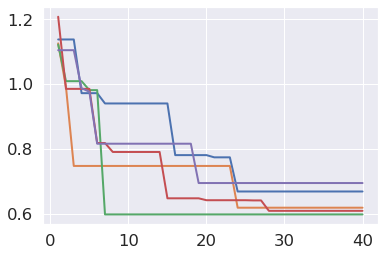

In [103]:
def plot_individual_convergence(dataframe, fold, n_calls):

    x_axis = list(range(1, n_calls + 1))
    y_axis = dataframe.loc[dataframe['Fold'] == fold]
    y_axis = y_axis['MAE/MAD'].tolist()

    plot = plt.plot(x_axis, y_axis)

num_folds = 5
for fold in range(1, num_folds + 1):
    plot_individual_convergence(cumulative_MAE_df, fold, 40)